In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm, trange
from timeit import timeit
from IPython.display import display, SVG
import graphviz

from ttn_torch import TIndex, TTNIndex, TTN, TTNModel, check_correct_init
from algebra import contract_up
from utils import *
from torchinfo import summary

FONTSIZE = 14

# Read tensors from TAIS files

In [3]:
numpy_to_torch_dtype_dict = {
        np.uint8      : torch.uint8,
        np.int8       : torch.int8,
        np.int16      : torch.int16,
        np.int32      : torch.int32,
        np.int64      : torch.int64,
        np.float16    : torch.float16,
        np.float32    : torch.float32,
        np.float64    : torch.float64,
        np.complex64  : torch.complex64,
        np.complex128 : torch.complex128
    }

In [4]:
elements_dir = 'trenti_models/metis/'
dtype = np.float64

with open(elements_dir + 'elements.bin') as f:
    n_elements = np.fromfile(f, dtype=np.int32, count=1)[0]
    
elements = np.fromfile(elements_dir + 'elements.bin', dtype=dtype, offset=4) # skip the first 4 bytes (int32 header containing the number of elements)
modes_file = open(elements_dir + 'modes.txt', 'r')

In [5]:
print('elements:', elements.shape, n_elements)

elements: (1792,) 1792


In [6]:
modes_file.seek(13)
line = modes_file.readline()
leg_tags = []
leg_dims = []
tensor_dict = {}
offset = 0
n_tensors = 0
while line:
    if line != '\n':
        splits = line.strip('\n').split(' ')
        leg_tags.append(splits[0])
        leg_dims.append(int(splits[1]))
    else:
        layer, layer_idx = [int(i) for i in leg_tags[-1].split(',')[-1].split('.')]
        tindex = TTNIndex(layer, layer_idx)
        print(f"read tensor {n_tensors}:", tindex, "\twith legs_dim:", leg_dims)
        n_tensors += 1
        n_elements = np.prod(leg_dims)
        tensor = torch.tensor(elements[offset:offset + n_elements], dtype=numpy_to_torch_dtype_dict[dtype]).reshape(list(np.array(leg_dims)[[2, 1, 0]])).permute(2, 1, 0)
        offset += n_elements
        tensor_dict[tindex] = tensor
        leg_tags.clear()
        leg_dims.clear()
    line = modes_file.readline()

layer, layer_idx = 0, 0
tindex = TTNIndex(layer, layer_idx)
print(f"read tensor {n_tensors}:", tindex, "\twith legs_dim:", leg_dims)   
n_elements = np.prod(leg_dims)
tensor = torch.tensor(elements[offset:offset + n_elements], dtype=numpy_to_torch_dtype_dict[dtype]).reshape(list(np.array(leg_dims)[[2, 1, 0]])).permute(2, 1, 0)
offset += n_elements
tensor_dict[tindex] = tensor
leg_tags.clear()
leg_dims.clear()

read tensor 0: 3.0 	with legs_dim: [2, 2, 4]
read tensor 1: 3.1 	with legs_dim: [2, 2, 4]
read tensor 2: 3.2 	with legs_dim: [2, 2, 4]
read tensor 3: 3.3 	with legs_dim: [2, 2, 4]
read tensor 4: 3.4 	with legs_dim: [2, 2, 4]
read tensor 5: 3.5 	with legs_dim: [2, 2, 4]
read tensor 6: 3.6 	with legs_dim: [2, 2, 4]
read tensor 7: 3.7 	with legs_dim: [2, 2, 4]
read tensor 8: 2.0 	with legs_dim: [4, 4, 8]
read tensor 9: 2.1 	with legs_dim: [4, 4, 8]
read tensor 10: 2.2 	with legs_dim: [4, 4, 8]
read tensor 11: 2.3 	with legs_dim: [4, 4, 8]
read tensor 12: 1.0 	with legs_dim: [8, 8, 8]
read tensor 13: 1.1 	with legs_dim: [8, 8, 8]
read tensor 14: 0.0 	with legs_dim: [8, 8, 2]


# construct TTN

In [7]:
sorted_tensors = {k: v for k, v in sorted(tensor_dict.items(), key=lambda item: item[0])}
last_key = list(sorted_tensors.keys())[-1]
first_key = list(sorted_tensors.keys())[0]
n_feat = 2**(last_key.layer+1)
n_phys = sorted_tensors[last_key].shape[0]
n_labels = sorted_tensors[first_key].shape[-1]
bond_dim = sorted_tensors[first_key].shape[1]

In [8]:
ttn = TTNModel(n_features=n_feat, n_phys=n_phys, n_labels=n_labels, bond_dim=bond_dim, dtype=numpy_to_torch_dtype_dict[dtype], device='cuda')
ttn.tensors = list(sorted_tensors.values())
ttn.initialize(False)

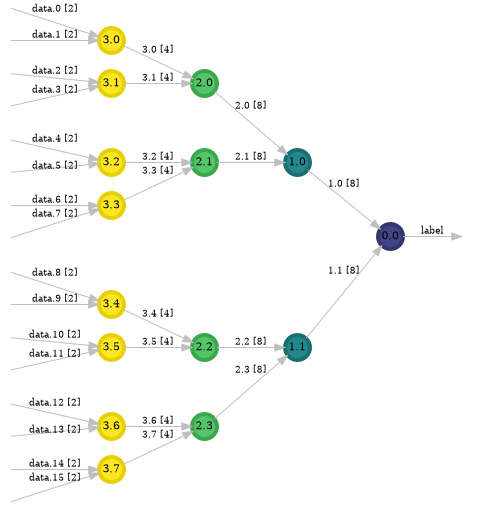

In [9]:
ttn.draw()

In [12]:
summary(ttn, input_size=(10, n_feat, n_phys), device='cuda', dtypes=[numpy_to_torch_dtype_dict[dtype]])

Layer (type:depth-idx)                   Output Shape              Param #
TTNModel                                 [10, 2]                   1,792
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [20]:
np.savez(elements_dir + f'weights.npz', **{key.name : value.cpu().detach() for key, value in ttn._TTN__tensor_map.items()})

# Load data and predict

In [10]:
def spinMap(x: np.ndarray):
    cos = np.cos(x*np.pi/2)
    sin = np.sin(x*np.pi/2)
        
    assert(np.allclose(cos**2 + sin**2, 1.0))
    return np.stack((cos, sin), axis=-1)

def polyMap(x: np.ndarray, dim: int=2):
    p_n = [x**i for i in range(dim)]
    result = np.stack(p_n, axis=-1)
    result /= np.linalg.norm(result, axis=-1, keepdims=True)
    assert(np.allclose(np.sum(result**2, axis=-1), 1.0))
    return result


mappings_dict = { 'spin': spinMap, 'poly': polyMap }

In [12]:
imsize = '8x16'
datadir = '../data/stripeimages/'
n_samples = 10000
mapping = 'poly'

x_train = np.load(datadir + imsize + 'train.npy')[:n_samples]
y_train = np.load(datadir + imsize + 'train_labels.npy')[:n_samples]
x_test = np.load(datadir + imsize + 'test.npy')[:n_samples]
y_test = np.load(datadir + imsize + 'test_labels.npy')[:n_samples]

x_train = mappings_dict[mapping](x_train.reshape(x_train.shape[0], -1))
x_test = mappings_dict[mapping](x_test.reshape(x_test.shape[0], -1))

x_train = torch.tensor(x_train, dtype=numpy_to_torch_dtype_dict[dtype], device='cuda')
x_test = torch.tensor(x_test, dtype=numpy_to_torch_dtype_dict[dtype], device='cuda')

true_pred_train = np.loadtxt(elements_dir + '../train1/predictions_train.txt')
true_pred_test = np.loadtxt(elements_dir + '../train1/predictions_test.txt')
gpu_pred_cpp = np.loadtxt(elements_dir + 'gpu_predictions_batch.txt')
print('x_train:', x_train.shape, '\ny_train:', y_train.shape, '\nx_test:', x_test.shape, '\ny_test:', y_test.shape, '\ntrue_pred:', true_pred_train.shape)

x_train: torch.Size([10000, 128, 2]) 
y_train: (10000,) 
x_test: torch.Size([1000, 128, 2]) 
y_test: (1000,) 
true_pred: (10000, 2)


In [13]:
x_test[0,0]

tensor([0.7071, 0.7071], device='cuda:0', dtype=torch.float64)

In [14]:
ttn.eval()
pred_time = timeit(lambda: ttn(x_train), number=100)/100
gpu_pred_train = ttn(x_train).cpu().detach().numpy()
gpu_pred_test = ttn(x_test).cpu().detach().numpy()

In [15]:
pred_time / x_train.shape[0]

1.6944516189978456e-06

In [16]:
np.sum(gpu_pred_cpp, axis=1).mean(), np.sum(gpu_pred_train, axis=1).mean(), np.sum(gpu_pred_test, axis=1).mean()

(0.0293920694230278, 0.029408259626954206, 0.029392068654420782)

In [22]:
np.allclose(gpu_pred_test, gpu_pred_cpp, rtol=1e-6, atol=1e-5)

True

In [32]:
gpu_prob_train = gpu_pred_train**2 + 1e-18
gpu_prob_test = gpu_pred_test**2 + 1e-18

gpu_prob_train = gpu_prob_train / np.sum(gpu_prob_train, axis=1, keepdims=True)
gpu_prob_test = gpu_prob_test / np.sum(gpu_prob_test, axis=1, keepdims=True)
gpu_prob_test

array([[9.99975250e-01, 2.47498627e-05],
       [9.99999837e-01, 1.63425463e-07],
       [9.99996373e-01, 3.62692386e-06],
       ...,
       [9.99999922e-01, 7.82640517e-08],
       [1.94366401e-06, 9.99998056e-01],
       [1.00000000e+00, 4.80882487e-10]])

In [18]:
gpu_prob_train = gpu_pred_train
gpu_prob_test = gpu_pred_test

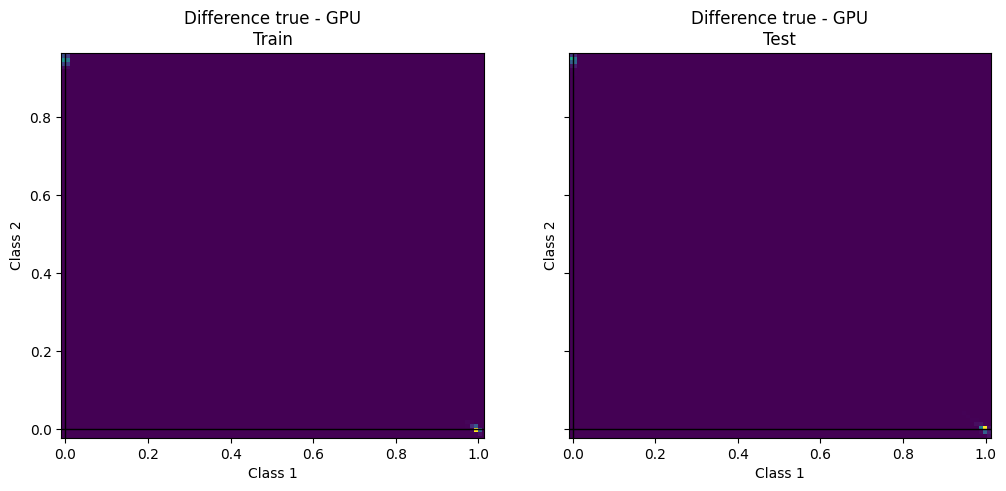

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
axs[0].hist2d(*(true_pred_train-gpu_prob_train).T, bins=100)
axs[0].set_title("Difference true - GPU\nTrain")
axs[0].set_xlabel("Class 1")
axs[0].set_ylabel("Class 2")
#ax.set_xlim(-1, 1)
#ax.set_ylim(-0.5, 1)

axs[0].axhline(0, color='black', lw=1)
axs[0].axvline(0, color='black', lw=1)


axs[1].hist2d(*(true_pred_test-gpu_prob_test).T, bins=100)
axs[1].set_title("Difference true - GPU\nTest")
axs[1].set_xlabel("Class 1")
axs[1].set_ylabel("Class 2")
#ax.set_xlim(-1, 1)
#ax.set_ylim(-0.5, 1)

axs[1].axhline(0, color='black', lw=1)
axs[1].axvline(0, color='black', lw=1)

#fig.savefig(f'difference_f{x_test.shape[1]}_c{8}_id{0}.png', dpi=600)

## BB data

In [14]:
train_dl, test_dl, features = get_bb_data_loaders(1000)

In [13]:
ttn.eval()
ttn.to('cuda')

train_out = get_output(ttn, 'cuda', train_dl)
test_out = get_output(ttn, 'cuda', test_dl)

#np.save('trenti_models/bd8/train_out.npy', train_out)
#np.save('trenti_models/bd8/test_out.npy', test_out)

train_out.sum(axis=1).mean(), test_out.sum(axis=1).mean()


test: 100%|██████████| 110/110 [00:00<00:00, 145.69it/s]


(tensor(0.9875, dtype=torch.float64), tensor(0.9871, dtype=torch.float64))

In [15]:
train_data = []
test_data = []

train_labels = []
test_labels = []

for x, y in train_dl:
    train_data.append(x)
    train_labels.append(y)

for x, y in test_dl:
    test_data.append(x)
    test_labels.append(y)

train_data = torch.cat(train_data, dim=0)
test_data = torch.cat(test_data, dim=0)
train_labels = torch.cat(train_labels, dim=0)
test_labels = torch.cat(test_labels, dim=0)

#np.save('../data/bbdata/train_data.npy', train_data.cpu().detach().numpy())
#np.save('../data/bbdata/test_data.npy', test_data.cpu().detach().numpy())
np.save('../data/bbdata/train_labels.npy', train_labels.cpu().detach().numpy())
np.save('../data/bbdata/test_labels.npy', test_labels.cpu().detach().numpy())


## get the model

In [4]:
bd = 8
weights_dict = np.load(f'trenti_models/train_lhcb_bd{bd}/tensors.npz')
weights = [torch.tensor(weights_dict[key.name], dtype=torch.float64) for key in sorted([TIndex(name, []) for name in weights_dict.keys()])]
model = TTNModel(n_features=16, n_phys=2, n_labels=2, bond_dim=bd, dtype=torch.float64, device='cuda')
model.tensors = weights
model.initialize(False)

In [7]:
len(weights)

15

(array([  9.,   2.,   6.,   7.,  21.,   8.,   4.,   9.,  17.,  25.,  54.,
         81., 144., 301., 537., 757., 356., 186.,  81.,  68.,  29.,  18.,
          7.,   0.,   3.,  10.,   4.,   4.,   4.,   4.]),
 array([-0.99978861, -0.93391737, -0.86804613, -0.80217489, -0.73630365,
        -0.67043241, -0.60456117, -0.53868993, -0.47281868, -0.40694744,
        -0.3410762 , -0.27520496, -0.20933372, -0.14346248, -0.07759124,
        -0.01172   ,  0.05415124,  0.12002248,  0.18589372,  0.25176496,
         0.3176362 ,  0.38350744,  0.44937868,  0.51524992,  0.58112116,
         0.6469924 ,  0.71286364,  0.77873489,  0.84460613,  0.91047737,
         0.97634861]),
 <BarContainer object of 30 artists>)

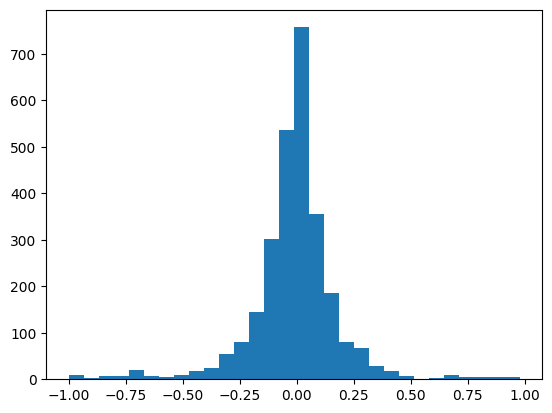

In [81]:
plt.hist(np.concatenate([weight.flatten() for weight in weights[1:]]), bins=30)

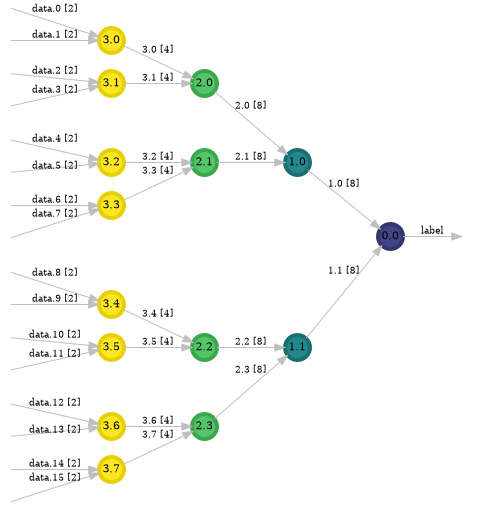

In [5]:
model.draw()

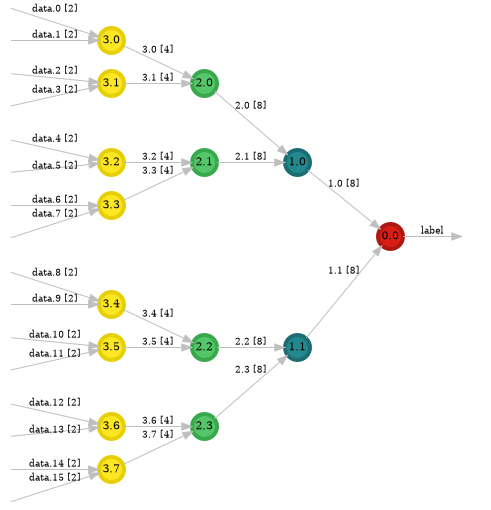

In [40]:
model.canonicalize('0.0')
model.draw()

(array([2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        5.000e+00, 2.000e+00, 2.200e+01, 1.030e+02, 1.312e+03, 2.910e+02,
        3.500e+01, 2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        4.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([-4.78988389, -4.34684311, -3.90380232, -3.46076154, -3.01772075,
        -2.57467997, -2.13163919, -1.6885984 , -1.24555762, -0.80251683,
        -0.35947605,  0.08356474,  0.52660552,  0.9696463 ,  1.41268709,
         1.85572787,  2.29876866,  2.74180944,  3.18485023,  3.62789101,
         4.07093179,  4.51397258,  4.95701336,  5.40005415,  5.84309493,
         6.28613572,  6.7291765 ,  7.17221728,  7.61525807,  8.05829885,
         8.50133964]),
 <BarContainer object of 30 artists>)

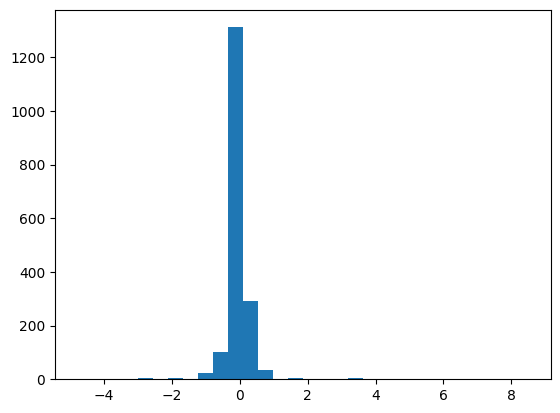

In [42]:
plt.hist(np.concatenate([weight.detach().numpy().flatten() for weight in model.tensors]), bins=30)

In [58]:
weights[0]

tensor([[[ 8.5013e+00,  8.4894e+00],
         [ 3.0144e+00, -3.7959e+00],
         [ 2.8980e+00, -8.3417e-02],
         [-5.0834e-01,  1.7756e+00],
         [ 1.4290e-01, -2.3170e-01],
         [-8.9678e-02, -6.3371e-02],
         [ 2.9869e-01, -5.3713e-01],
         [-9.8374e-02, -7.3057e-02]],

        [[ 8.5117e-01,  3.4443e+00],
         [-4.5109e-01,  2.7497e+00],
         [-4.7364e+00, -3.9349e+00],
         [ 1.9802e+00, -3.3940e+00],
         [ 4.2104e-01, -5.3781e-01],
         [ 3.2986e-01, -1.3560e-01],
         [ 4.5384e-01, -2.5153e-01],
         [-1.2541e-01, -2.3339e-02]],

        [[ 4.7899e+00, -3.4592e+00],
         [-4.4058e-01,  1.4588e+00],
         [-1.7963e+00, -2.5710e-02],
         [-7.3307e-01,  6.6979e-01],
         [ 5.2093e-01, -4.4428e-01],
         [ 1.1422e-01, -2.9492e-01],
         [-4.0163e-02, -3.5271e-01],
         [ 2.1373e-01,  1.6769e-01]],

        [[ 4.1561e-03,  1.8695e+00],
         [-3.4434e+00,  3.3053e+00],
         [ 7.5034e-01, -5.1912e-

In [85]:
top = model['0.0']['0.0']
top / torch.linalg.norm(top)

tensor([[[ 3.9532e-01,  4.0802e-01],
         [-1.6869e-01,  1.7237e-01],
         [-6.0423e-02, -2.5316e-02],
         [-5.6808e-02,  6.2654e-02],
         [-7.0555e-03,  1.1829e-02],
         [-2.4828e-02,  2.6725e-02],
         [ 2.4321e-02, -9.0208e-04],
         [ 4.1420e-03,  6.4217e-04],
         [-1.5942e-02,  1.5025e-02],
         [-1.0380e-02,  1.8886e-02],
         [ 3.4000e-03,  6.2451e-03],
         [-5.1675e-03,  1.8521e-02],
         [ 1.1408e-02, -1.2502e-02],
         [ 7.3964e-03,  9.6162e-03],
         [-7.4392e-03,  8.9661e-03],
         [ 1.9546e-03, -1.0926e-02]],

        [[-1.1286e-02,  1.3704e-01],
         [ 2.6038e-02, -6.1570e-02],
         [ 1.6603e-01,  2.3059e-01],
         [ 1.6146e-01, -1.0685e-01],
         [-2.5256e-02,  5.6385e-03],
         [-1.4895e-02, -4.6197e-03],
         [ 6.7435e-03, -3.3924e-02],
         [-1.2518e-02, -1.3275e-02],
         [-5.7448e-03,  7.4743e-03],
         [-3.8212e-02,  2.0542e-03],
         [ 2.2181e-03, -6.3487e-03],

In [80]:
isometrised = True
for tag in model.indices[1:]:
    tensor = torch.tensor(weights_dict[tag.name], dtype=torch.float64) #model[tag][tag]
    isometrised = isometrised and torch.allclose(torch.einsum('ijk,ijl->kl', tensor, tensor), torch.eye(tensor.shape[-1], dtype=torch.float64), atol=1e-6)
print(isometrised)

True


In [43]:
np.concatenate([weight.detach().numpy().flatten() for weight in model.tensors])

array([ 8.50133964,  8.48939149, -3.01437541, ...,  0.16625967,
       -0.64357744,  0.74473716])

In [ ]:
tops = torch.unbind(model.tensors[0], dim=-1)

# FSOCO

In [3]:
train_dl, test_dl, n_feat = get_fsoco_data_loaders(1000)

In [5]:

weights_dict = np.load(f'fsoco_models/train/32x32/tensors.npz')
bond_dim, n_labels = weights_dict['0.0'].shape[1:]
n_phys = 4
device = 'cpu'

weights = [torch.tensor(weights_dict[key.name], dtype=torch.float64, device=device) for key in sorted([TIndex(name, []) for name in weights_dict.keys()])]
ttn = TTNModel(n_features=n_feat, n_phys=n_phys, n_labels=n_labels, bond_dim=bond_dim, dtype=torch.float64, device=device)
ttn.tensors = weights
ttn.initialize(False)

In [7]:
preds = []
for data, _ in tqdm(train_dl):
    data = data.to(device)
    preds.append( ttn(data).detach().cpu() )

preds = torch.cat(preds, dim=0)

  0%|          | 0/33 [00:00<?, ?it/s]

100%|██████████| 33/33 [03:16<00:00,  5.94s/it]


In [9]:
preds.shape

torch.Size([32540, 5])